In [1]:
import os
import re
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [18]:
rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [19]:
# 3점 이상만 남긴다. 
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [20]:
# ratings 컬럼의 이름을 counts로 바꾼다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [21]:
# 영화 제목을 보기 위해 메타 데이터를 로드
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
data = pd.merge(ratings, movies)

In [23]:
using_cols = ['user_id', 'title', 'counts']
data = data[using_cols]
data.head(10)

,user_id,title,counts
0,1,One Flew Over the Cuckoo's Nest (1975),5
1,2,One Flew Over the Cuckoo's Nest (1975),5
2,12,One Flew Over the Cuckoo's Nest (1975),4
3,15,One Flew Over the Cuckoo's Nest (1975),4
4,17,One Flew Over the Cuckoo's Nest (1975),5
5,18,One Flew Over the Cuckoo's Nest (1975),4
6,19,One Flew Over the Cuckoo's Nest (1975),5
7,24,One Flew Over the Cuckoo's Nest (1975),5
8,28,One Flew Over the Cuckoo's Nest (1975),3
9,33,One Flew Over the Cuckoo's Nest (1975),5


In [24]:
title_count = data.groupby('title')['user_id'].count()
title_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

In [25]:
my_favorite = ['Toy Story (1995)' , 'Matrix, The (1999)' ,'Terminator 2: Judgment Day (1991)' ,'Terminator, The (1984)' ,'Jurassic Park (1993)']


my_playlist = pd.DataFrame({'user_id':['jaeheon']*5, 'title':my_favorite, 'counts':[5]*5})
if not data.isin({'user_id':['jaeheon']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면 위에 임의로 만든 데이터 추가
    data = data.append(my_playlist)
    
data.tail(10)

,user_id,title,counts
836473,5851,One Little Indian (1973),5
836474,5854,Slaughterhouse (1987),4
836475,5854,"Promise, The (Versprechen, Das) (1994)",3
836476,5938,"Five Wives, Three Secretaries and Me (1998)",4
836477,5948,Identification of a Woman (Identificazione di ...,5
0,jaeheon,Toy Story (1995),5
1,jaeheon,"Matrix, The (1999)",5
2,jaeheon,Terminator 2: Judgment Day (1991),5
3,jaeheon,"Terminator, The (1984)",5
4,jaeheon,Jurassic Park (1993),5


In [26]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = data['user_id'].unique()
title_unique = data['title'].unique()

# 유저, 영화 indexing하는 코드
user_to_idx = {v:k for k, v in enumerate(user_unique)}
title_to_idx = {v:k for k, v in enumerate(title_unique)}

In [27]:
print(user_to_idx['jaeheon'])  # 6040명의 유저 중 마지막으로 추가된 유저라서 6039이 나와야 한다. 
print(title_to_idx['Toy Story (1995)'])

6039
40


In [28]:
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):  # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data
else:
    print('user_id column indexing Fail!!')
    
# title_to_idx를 통해 artist 컬럼도 동일한 방식으로 인덱싱
temp_title_data = data['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(data):
    print('title column indexing OK!!')
    data['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

data

user_id column indexing OK!!
title column indexing OK!!


,user_id,title,counts
0,0,0,5
1,1,0,5
2,2,0,4
3,3,0,4
4,4,0,5
...,...,...,...
0,6039,40,5
1,6039,124,5
2,6039,92,5
3,6039,200,5


## CSR matrix

In [29]:
num_user = data['user_id'].nunique()
num_title = data['title'].nunique()

csr_data = csr_matrix((data.counts, (data.user_id, data.title)), shape=(num_user, num_title))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

## MF Modeling

In [30]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분으로, 학습 내용과는 무관
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [31]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=20, dtype=np.float32)

In [32]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [33]:
als_model.fit(csr_data_transpose)

  0%|          | 0/20 [00:00<?, ?it/s]

In [34]:
jaeheon, toy_story_1995 = user_to_idx['jaeheon'], title_to_idx['Toy Story (1995)']
jaeheon_vector, toy_story_1995_vector = als_model.user_factors[jaeheon], als_model.item_factors[toy_story_1995]

In [35]:
np.dot(jaeheon_vector, toy_story_1995_vector)

0.4543147

In [36]:
schindler = title_to_idx['Schindler\'s List (1993)']
schindler_vector = als_model.item_factors[schindler]
np.dot(jaeheon_vector, schindler_vector)

-0.031788077

In [37]:
favorite_title = 'Toy Story (1995)'
title_id = title_to_idx[favorite_title]
similar_title = als_model.similar_items(title_id, N=15)
similar_title

[(40, 1.0),
 (50, 0.7927995),
 (4, 0.57362604),
 (33, 0.5678631),
 (322, 0.53723264),
 (110, 0.5110421),
 (20, 0.4542232),
 (330, 0.44195113),
 (10, 0.40713805),
 (255, 0.39739925),
 (34, 0.35059378),
 (32, 0.3465018),
 (126, 0.3430065),
 (16, 0.33712),
 (160, 0.3340192)]

In [38]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in similar_title]

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Aladdin (1992)',
 'Babe (1995)',
 'Groundhog Day (1993)',
 'Pleasantville (1998)',
 'Lion King, The (1994)',
 'Beauty and the Beast (1991)',
 "There's Something About Mary (1998)",
 'Mulan (1998)',
 'Hercules (1997)',
 'Shakespeare in Love (1998)',
 'Tarzan (1999)',
 'Forrest Gump (1994)']

In [39]:
# 몇 번 더 반복해서 확인하기 위해 위의 코드 함수화
def get_similar_title(title_name: str):
    title_id = title_to_idx[title_name]
    similar_title = als_model.similar_items(title_id)
    similar_title = [idx_to_title[i[0]] for i in similar_title]
    return similar_title

In [40]:
get_similar_title('Terminator 2: Judgment Day (1991)')

['Terminator 2: Judgment Day (1991)',
 'Matrix, The (1999)',
 'Jurassic Park (1993)',
 'Total Recall (1990)',
 'Terminator, The (1984)',
 'Men in Black (1997)',
 'Fugitive, The (1993)',
 'Braveheart (1995)',
 'Schlafes Bruder (Brother of Sleep) (1995)',
 'Hunt for Red October, The (1990)']

## Recommendation

In [41]:
user = user_to_idx['jaeheon']
# recommend에서는 user*item CSR Matrix를 받는다. 
title_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
title_recommended

[(175, 0.5077258),
 (62, 0.4981243),
 (141, 0.3756351),
 (50, 0.34786263),
 (651, 0.32337514),
 (193, 0.31661588),
 (87, 0.2935068),
 (38, 0.28783768),
 (44, 0.281016),
 (75, 0.27844566),
 (317, 0.27822846),
 (117, 0.25569627),
 (145, 0.2512964),
 (22, 0.2464912),
 (194, 0.22846544),
 (680, 0.22312158),
 (375, 0.21882486),
 (64, 0.21115124),
 (4, 0.2073012),
 (685, 0.20545405)]

In [42]:
[idx_to_title[i[0]] for i in title_recommended]

['Men in Black (1997)',
 'Total Recall (1990)',
 'Fugitive, The (1993)',
 'Toy Story 2 (1999)',
 'Aliens (1986)',
 'Alien (1979)',
 'Braveheart (1995)',
 'Sixth Sense, The (1999)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Hunt for Red October, The (1990)',
 'Twelve Monkeys (1995)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Fifth Element, The (1997)',
 'Back to the Future (1985)',
 'Die Hard (1988)',
 'Blade Runner (1982)',
 'Face/Off (1997)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 "Bug's Life, A (1998)",
 'Planet of the Apes (1968)']

In [43]:
men_in_black = title_to_idx['Men in Black (1997)']
explain = als_model.explain(user, csr_data, itemid=men_in_black)

In [44]:
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Jurassic Park (1993)', 0.2853243264653374),
 ('Terminator 2: Judgment Day (1991)', 0.14513374316410307),
 ('Matrix, The (1999)', 0.0949527404763603),
 ('Toy Story (1995)', -0.0031868177220414446),
 ('Terminator, The (1984)', -0.020166093258160517)]

## Other Method

- ALS model을 사용하지 않고 근본적인(svd) 방법을 이용해보자.
- SVD는 행렬을 분해하는 방법으로 자세한 방법은 아래의 링크를 참고하자.
- [SVD](https://angeloyeo.github.io/2019/08/01/SVD.html)
- SVD를 통해 상관계수를 뽑고 '특정 영화와 관련된 상관계수가 높은 영화를 뽑아서 추천해준다.'

In [45]:
data = pd.merge(ratings, movies)

In [46]:
data.shape

(836478, 6)

In [47]:
data

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...
836473,5851,3607,5,957756608,One Little Indian (1973),Comedy|Drama|Western
836474,5854,3026,4,958346883,Slaughterhouse (1987),Horror
836475,5854,690,3,957744257,"Promise, The (Versprechen, Das) (1994)",Romance
836476,5938,2909,4,957273353,"Five Wives, Three Secretaries and Me (1998)",Documentary


### Pivot table

In [48]:
user_movie_rating = data.pivot_table('counts', index='user_id', columns='title').fillna(0)

In [50]:
user_movie_rating.shape

(6039, 3628)

In [51]:
user_movie_rating.head()

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
movie_user_rating = user_movie_rating.values.T # Transpose user-movie -> moive-user
movie_user_rating.shape

(3628, 6039)

## SVD(singular value decomposition)

In [53]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

SVD = TruncatedSVD(n_components=12)
matrix = SVD.fit_transform(movie_user_rating)
matrix.shape

(3628, 12)

In [54]:
corr = np.corrcoef(matrix)
corr.shape

(3628, 3628)

In [55]:
corr2 = corr[:200, :200]
corr2.shape

(200, 200)

<AxesSubplot:>

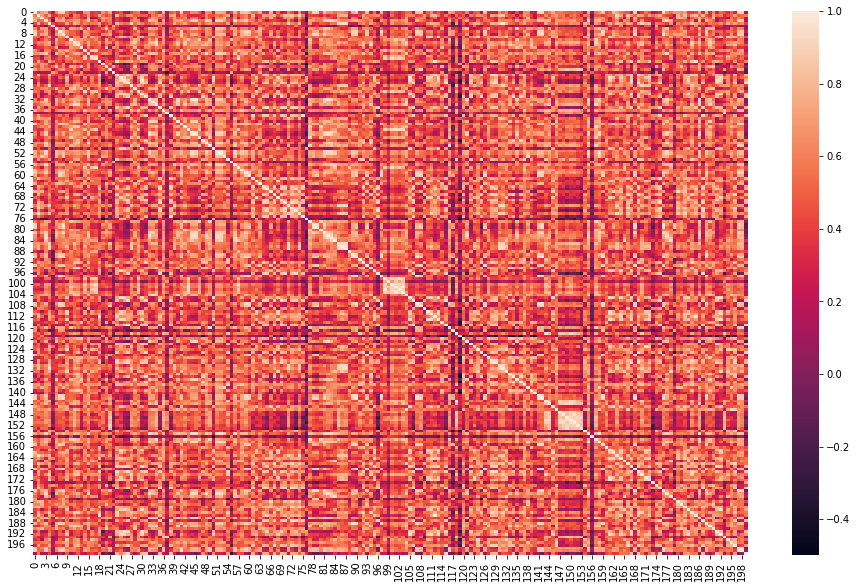

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
sns.heatmap(corr2)

In [60]:
movie_title_list

['$1,000,000 Duck (1971)',
 "'Night Mother (1986)",
 "'Til There Was You (1997)",
 "'burbs, The (1989)",
 '...And Justice for All (1979)',
 '1-900 (1994)',
 '10 Things I Hate About You (1999)',
 '101 Dalmatians (1961)',
 '101 Dalmatians (1996)',
 '12 Angry Men (1957)',
 '13th Warrior, The (1999)',
 '187 (1997)',
 '2 Days in the Valley (1996)',
 '20 Dates (1998)',
 '20,000 Leagues Under the Sea (1954)',
 '200 Cigarettes (1999)',
 '2001: A Space Odyssey (1968)',
 '2010 (1984)',
 '24 7: Twenty Four Seven (1997)',
 '24-hour Woman (1998)',
 '28 Days (2000)',
 '3 Ninjas: High Noon On Mega Mountain (1998)',
 '3 Strikes (2000)',
 '301, 302 (1995)',
 '39 Steps, The (1935)',
 '400 Blows, The (Les Quatre cents coups) (1959)',
 '42 Up (1998)',
 '52 Pick-Up (1986)',
 '54 (1998)',
 '7th Voyage of Sinbad, The (1958)',
 '8 1/2 (1963)',
 '8 1/2 Women (1999)',
 '8 Heads in a Duffel Bag (1997)',
 '8 Seconds (1994)',
 '8MM (1999)',
 'A Chef in Love (1996)',
 'Abbott and Costello Meet Frankenstein (1948)',

In [61]:
movie_title = user_movie_rating.columns
movie_title_list = list(movie_title)
coffey_hands = movie_title_list.index('Chambermaid on the Titanic, The (1998)')

In [62]:
corr_coffey_hands  = corr[coffey_hands]
list(movie_title[(corr_coffey_hands >= 0.9)])[:5]

['Afterglow (1997)',
 'Age of Innocence, The (1993)',
 'Angels and Insects (1995)',
 "Antonia's Line (Antonia) (1995)",
 'Artemisia (1997)']